Importing gempy



In [1]:
# Aux imports
import gempy as gp
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import gstools as gs
import pyvista as pv
import pyvistaqt as pvqt
import PVGeo
import glob
import random
from tqdm import tqdm
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from sklearn import preprocessing
from pyvista import set_plot_theme
np.random.seed(1515)
pd.set_option('precision', 2)
%matplotlib inline
set_plot_theme('document')

No module named 'osgeo'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\pasha\python\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We import a model from an existing folder, representing a subduction
zone with onlap relationships. The theano function is automatically
recombined to allow changes.




In [13]:
#define resolution and mesh size
reso=[50, 50, 50]
mesh_size = reso[0]*reso[1]*reso[2]
extent=[0, 2075, 0, 1000, -700, 100]
print(' mesh size: ' + str(mesh_size))

 mesh size: 125000


In [30]:
geo_data = gp.create_data('foresets', extent=extent, resolution=reso,
                          path_o="orientation_data_joined.csv",
                          path_i="point_data_joined.csv")

gp.map_stack_to_surfaces(geo_data, {"Strat_Series1": ('topo'),
                                    "Strat_Series2": ('SanhedongFm','HuakaizuoFm','UpperYunlongFm','LowerYunlongFm'),
                                    "Strat_Series3": ('HutoushiFm'),
                                    "Basement": ('basement')})

Active grids: ['regular']


,surface,series,order_surfaces,color,id
0,topo,Strat_Series1,1,#015482,1
1,SanhedongFm,Strat_Series2,1,#9f0052,2
2,HuakaizuoFm,Strat_Series2,2,#ffbe00,3
3,UpperYunlongFm,Strat_Series2,3,#728f02,4
4,LowerYunlongFm,Strat_Series2,4,#443988,5
5,HutoushiFm,Strat_Series3,1,#ff3f20,6
6,basement,Basement,1,#5DA629,7


In [31]:
geo_data.series.df['BottomRelation'][2]='Onlap'
#geo_data.series.df['BottomRelation'][0]='Fault'
#geo_data.set_is_fault(['Fault_Series'])
geo_data.series

,order_series,BottomRelation,isActive,isFault,isFinite
Strat_Series1,1,Erosion,True,False,False
Strat_Series2,2,Erosion,True,False,False
Strat_Series3,3,Onlap,True,False,False
Basement,4,Erosion,False,False,False


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


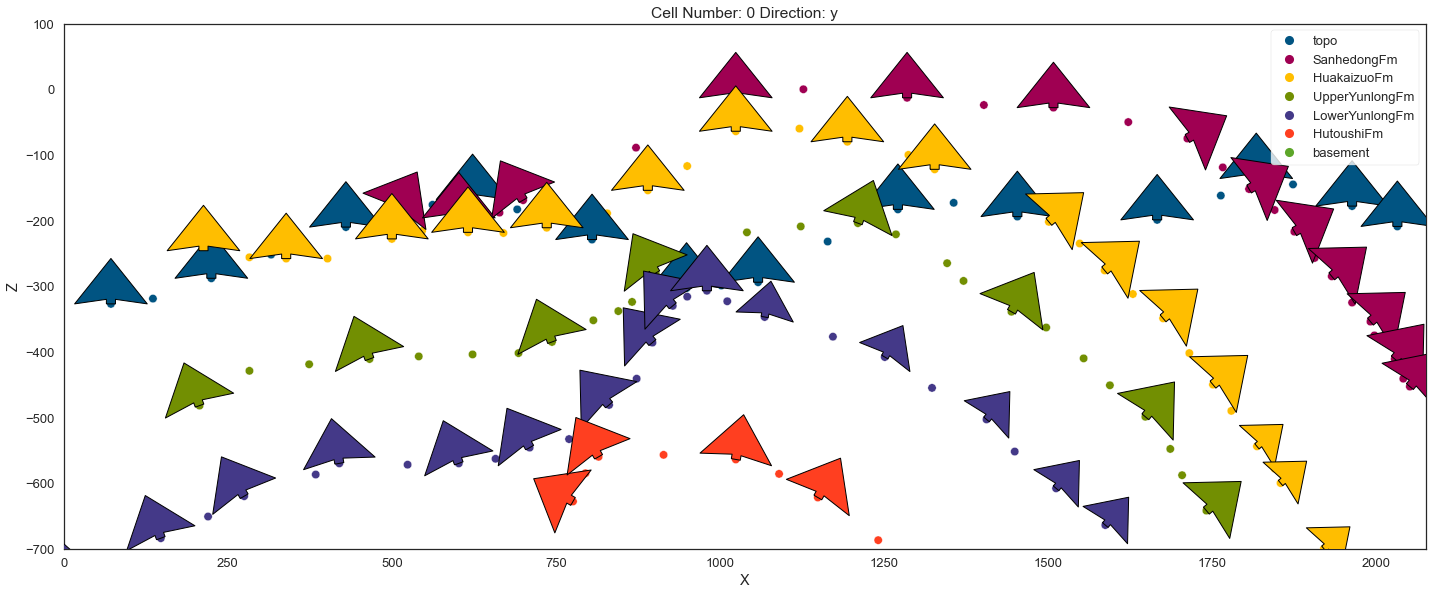

In [32]:
#for resolution of 40x40x40 : Isa - cell number=0; Hilton - cell number 35.5.

gp.plot_2d(geo_data, direction='y', cell_number=0, figsize=(20,20))

In [33]:
#set topography surface for good visualization
geo_data.set_topography()

[-60. 100.]
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[ 2.07500000e+01,  1.00000000e+01, -6.92000000e+02],
       [ 2.07500000e+01,  1.00000000e+01, -6.76000000e+02],
       [ 2.07500000e+01,  1.00000000e+01, -6.60000000e+02],
       ...,
       [ 2.07500000e+03,  9.59183673e+02,  8.51234957e-01],
       [ 2.07500000e+03,  9.79591837e+02,  1.39339297e+00],
       [ 2.07500000e+03,  1.00000000e+03,  9.71512794e+00]])

In [34]:
interp_data = gp.set_interpolator(geo_data, compile_theano=True,theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range                 2438.37
$C_o$                141562.5
drift equations  [3, 3, 3, 3]


In [35]:
%%time
sol = gp.compute_model(geo_data, compute_mesh=True, debug=False)

Wall time: 13.5 s


C:\Users\pasha\python\lib\site-packages\gempy\core\solution.py:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.geological_map = np.array(


C:\Users\pasha\python\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


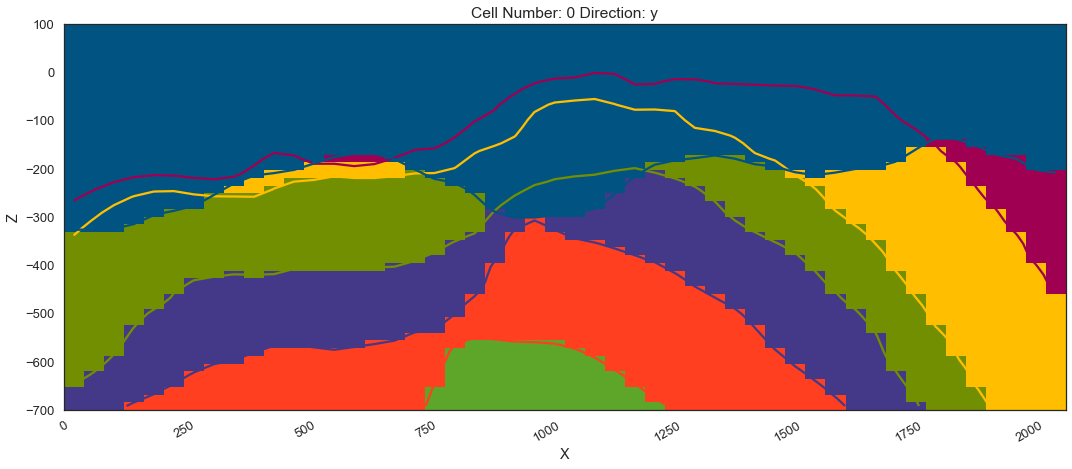

In [36]:
gp.plot_2d(geo_data, direction='y', cell_number=0, show_data=False,  figsize=(15,15))

In [10]:
p3d = gp.plot_3d(geo_data, plotter_type='background', show_lith=True, show_surfaces=True,  show_data=False, image=False,
                 show_topography=True,
                 kwargs_plot_structured_grid={'opacity': .6})

gp.save_model(geo_data)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


True

In [37]:
### User-defined functions
def extract_domain(sol, unit):
    '''
    Extract domain coordinates from gempy model by unit name
    arguments:
        sol: Gempy solution object.
        unit: gempy unit by index
    returns:
        dom_x, dom_y, dom_z: coordinates of domain
    '''

    # new version with rounding, definitely necessary
    rounded_lithblock = sol.lith_block.round(0)
    rounded_lithblock = rounded_lithblock.astype(int)

    # mask by array of input surfaces (by id, can be from different series)
    mask = np.isin(rounded_lithblock, unit)

    # get coordinates by mask, mesh_size is defined on in[55]
    #krig_lith = sol.lith_block[mask]
    dom_grid = sol.grid.values[:mesh_size][mask]

    dom_x = dom_grid[:,0]
    dom_y = dom_grid[:,1]
    dom_z = dom_grid[:,2]

    return dom_x, dom_y, dom_z

In [38]:
unit_count=int(np.max(sol.lith_block.round(0)))
series_count=len(sol.scalar_field_matrix)
unit_count, series_count

(7, 3)

### Geostatistics and Kriging
the script below is designed to use two different mineral grading parameters and eventually visualize both in the same grid of the model

In [13]:
#load csv file and introduce it to pandas dataframe
df=pd.read_csv('kriging_data_all.csv')
df

,X,Y,Z,grade_value,grade,section
0,1383,0,-208,7.82,Zn-PB,AB
1,1392,0,-221,7.88,Zn-PB,AB
2,1404,0,-231,7.89,Zn-PB,AB
3,1393,0,-216,7.83,Zn-PB,AB
4,1426,0,-245,7.89,Zn-PB,AB
...,...,...,...,...,...,...
85,1794,0,-546,7.81,Zn-PB,AB
86,1809,0,-560,7.89,Zn-PB,AB
87,1817,0,-567,7.86,Zn-PB,AB
88,1821,0,-582,7.87,Zn-PB,AB


In [14]:
domain_x, domain_y, domain_z = extract_domain(sol, (5))

# grid coordinate preparation
coordinates = np.array([domain_x, domain_y, domain_z])
coordinates = coordinates.swapaxes(0,1)

In [15]:
# define kriging points coordinates and grade values (Cu)
n=len(df.iloc[:,2])
x = df.iloc[:n,0]
y = df.iloc[:n,1]
z = df.iloc[:n,2]
cond_pos = np.array([x,y,z])
cond_val = df.iloc[:n,3]

In [16]:
# Define kriging function (Cu)
#(CondSRF - conditional spatial random fields)
model = gs.Exponential(dim=3, var=np.var(cond_val), len_scale=200)
krige = gs.krige.Ordinary(model, cond_pos, cond_val)

# perform kriging
krige((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')
# alternatively fior SGS
#cond_srf((coordinates[:,0],coordinates[:,1], coordinates[:,2]), mesh_type='unstructured')

# just convenience rename
field= krige

In [17]:
# convert to pyvista mesh
pc = field.to_pyvista()

In [27]:
# 3D plotting example of Cu krige
spacing = lambda arr: np.unique(np.diff(np.unique(arr)))
voxelsize = spacing(pc.points[:,0]), spacing(pc.points[:,1]), spacing(pc.points[:,2])

pc = pc.cast_to_unstructured_grid()

grade = PVGeo.filters.VoxelizePoints(dx=voxelsize[0][0], dy=voxelsize[1][0], dz=voxelsize[2][0], 
                                        estimate=False).apply(pc)


#a = pc_Cu.plot('3d_field')
#p = pvqt.BackgroundPlotter(pc)


gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=False,
                kwargs_plot_structured_grid={'opacity': .8})

gpv.p.add_mesh(grade, opacity=1,  show_edges=False, clim=[7.8, 7.9], lighting=False, cmap="viridis")

(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)000001E7A16AB160

In [19]:
#define grade intervals and check the count of voxels corresponding to the same interval
ore_interval1=[]

for index in tqdm(range(0, len(grade.active_scalars))):
    #for Horizon I:
    if grade.active_scalars[index]>7.8:
        ore_interval1.append(grade.active_scalars[index])
   
        
#calculate volume of total voxels corresponding to a certain ore grade interval
voxel_volume=((extent[1]-extent[0])/reso[0])*((extent[3]-extent[2])/reso[1])*((extent[5]-extent[4])/reso[2])

ore_avrg_grade=np.mean(ore_interval1)
volume=len(ore_interval1)*(voxel_volume)
print('Horizon1=',volume)
print("Average ore grade=", ore_avrg_grade)

100%|████████████████████████████████| 189657/189657 [02:19<00:00, 1360.26it/s]

Horizon1= 314830620.0
Average ore grade= 7.853333376679228


### Extract kriged data

In [18]:
%%time
main_array=pc.points.tolist()
added_array=grade.active_scalars.tolist()
n=len(main_array)

for index in range(0,n,1):
    main_array[index].append(added_array[index])
grade=pd.DataFrame(main_array, columns=['X','Y','Z','grade'])
grade

Wall time: 29.9 ms


,X,Y,Z,grade
0,20.75,10.0,-644.0,7.85
1,20.75,10.0,-628.0,7.85
2,20.75,10.0,-612.0,7.85
3,20.75,10.0,-596.0,7.85
4,20.75,10.0,-580.0,7.85
...,...,...,...,...
23712,1971.25,270.0,-692.0,7.85
23713,1971.25,290.0,-692.0,7.85
23714,1971.25,310.0,-692.0,7.85
23715,1971.25,330.0,-692.0,7.85


In [19]:
#drill boreholess!!
def krige_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(grade)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in grade.itertuples():
            if (grade.iloc[rand_ind[index]].X==row.X and grade.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.grade])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','grade']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict
        
boreholes=krige_boreholes(100)

100%|████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


In [20]:
drill_all = pd.concat(boreholes.values(), ignore_index=True)
drill_all

,X,Y,Z,grade,borehole
0,103.75,950.0,-452.0,7.85,1
1,103.75,950.0,-436.0,7.85,1
2,103.75,950.0,-420.0,7.85,1
3,103.75,950.0,-404.0,7.85,1
4,103.75,950.0,-388.0,7.85,1
...,...,...,...,...,...
1150,145.25,870.0,-372.0,7.85,100
1151,145.25,870.0,-356.0,7.85,100
1152,145.25,870.0,-340.0,7.85,100
1153,145.25,870.0,-324.0,7.85,100


In [24]:
list_tempo=[]
for index in range(0,len(drill_all),5):
    list_tempo.append(drill_all.iloc[index])
br=pd.DataFrame(list_tempo)

br.to_csv('3_kriging_100.csv')
br

,X,Y,Z,grade,borehole
0,103.75,950.0,-452.0,7.85,1.0
5,103.75,950.0,-372.0,7.85,1.0
10,103.75,950.0,-292.0,7.85,1.0
15,103.75,350.0,-468.0,7.85,2.0
20,103.75,350.0,-388.0,7.85,2.0
...,...,...,...,...,...
1130,1763.75,510.0,-516.0,7.85,98.0
1135,103.75,510.0,-468.0,7.85,99.0
1140,103.75,510.0,-388.0,7.85,99.0
1145,145.25,870.0,-452.0,7.85,100.0


In [25]:
vertices = drill_all[['X','Y','Z']].values
kriged=pv.PolyData(vertices)
kriged['grade'] = drill_all['grade'].values
kriged

PolyData (0x230008b0a00)
  N Cells:	1155
  N Points:	1155
  X Bounds:	2.075e+01, 1.888e+03
  Y Bounds:	1.000e+01, 9.900e+02
  Z Bounds:	-6.920e+02, -1.960e+02
  N Arrays:	1

In [26]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(kriged, scalars='grade', opacity=1, cmap='viridis', point_size=5)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000023000882A60

### Extract orientation data from the solution

In [39]:
#define the function to calculate gradient (dict_spec)

def get_gradient(sol, res, dim):
    '''
    Calculate gradient from model solution
    '''
    # scalar field as meshgrid
    dict_all={}
    dict_spec={}
    for index in range(0,series_count,1):
        scalar_mgrid = sol.scalar_field_matrix[index].reshape(res)

        # calculate gradient
        gx, gy, gz = np.gradient(scalar_mgrid)

       
        vectors = np.array([gx.reshape(int(res[0] ** dim)), gy.reshape(int(res[0] ** dim)), gz.reshape(int(res[0] ** dim))])
        vectors = np.swapaxes(vectors, 0, 1)
        vectors = preprocessing.normalize(vectors, norm='l2')
        dict_all.update({index:vectors})
         
    
    for index in range(0,series_count,1):
            data_temp = pd.DataFrame(dict_all[index])
            dict_spec.update({'series_{}'.format(index):data_temp})
    return dict_spec

dict_spec=get_gradient(sol, res=[50,50,50], dim=3)

#define cell locations and correspoding domain name
x=sol.grid.regular_grid.values[:, 0]
y=sol.grid.regular_grid.values[:, 1]
z=sol.grid.regular_grid.values[:, 2]
formation=sol.lith_block

#add cell locations and domain names to the gradient dataframe
for key,value in dict_spec.items():
    #load coordinate and formation array to the whole series dataframes
    value["X"]=x
    value['Y']=y
    value['Z']=z
    value['formation']=formation
    #value = value.reset_index()
    #define column names
    value.columns=['G_x','G_y','G_z','X','Y','Z','formation'] 

In [40]:
#extract and save necessary orientation data for each strat series
dict_spec['series_0']=dict_spec['series_0'][dict_spec['series_0'].formation==1]

dict_spec['series_1'] = dict_spec['series_1'].loc[(dict_spec['series_1'].formation > 1) & (dict_spec['series_1'].formation < 6)]

dict_spec['series_2']=dict_spec['series_2'][dict_spec['series_2'].formation==6]

#join all orientation data into one data frame
orientations = pd.concat([dict_spec['series_0'],dict_spec['series_1'],dict_spec['series_2']], ignore_index=True)

#extract ideal case grid and define it as "ideal"
unit=range(0,unit_count+1)
for index in unit:
    domain_x, domain_y, domain_z = extract_domain(sol, (unit[index+1]))
    coordinates = np.array([domain_x, domain_y, domain_z])
    coordinates = coordinates.swapaxes(0,1)
    data=pd.DataFrame(coordinates, columns=['X','Y','Z'])
    data.loc[:, 'formation'] =float(unit[index+1])
    data.to_csv(r'data_extracted/ideal/unit_{}.csv'.format(unit[index+1]), mode="w", index=False)

IndexError: range object index out of range

In [41]:
# if you want to join all files in the same folder
path =r'data_extracted/ideal/'

filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
ideal = pd.concat(dfs, ignore_index=True)

#compare ideal and orientation grid and extract the cells that are the same
df_same = orientations.merge(ideal, left_on=('X','Y','Z','formation'), right_on=('X','Y','Z','formation'), how='inner')
df_same= df_same[df_same.formation != unit_count]
df_same

,G_x,G_y,G_z,X,Y,Z,formation
0,3.51e-03,-2.73e-03,1.00,20.75,10.0,-324.0,1.0
1,-8.30e-03,-5.81e-03,1.00,20.75,10.0,-308.0,1.0
2,-3.56e-02,-8.93e-03,1.00,20.75,10.0,-292.0,1.0
3,-7.48e-02,-1.13e-02,1.00,20.75,10.0,-276.0,1.0
4,-1.20e-01,-1.28e-02,0.99,20.75,10.0,-260.0,1.0
...,...,...,...,...,...,...,...
122882,7.22e-01,-4.08e-02,0.69,2054.25,230.0,-676.0,3.0
122883,7.19e-01,-4.43e-02,0.69,2054.25,250.0,-692.0,3.0
122884,7.20e-01,-4.36e-02,0.69,2054.25,250.0,-676.0,3.0
122885,7.17e-01,-4.69e-02,0.70,2054.25,270.0,-692.0,3.0


In [42]:
#drill boreholess!!
def d_boreholes(b_count):
    borehole_count=range(0,b_count,1)
    rand_ind=random.sample(range(0,len(df_same)),b_count)
    dict_all={}
    boreholes_dict={}

    for index in tqdm(borehole_count):
        list_temp=[]
        for row in df_same.itertuples():
            if (df_same.iloc[rand_ind[index]].X==row.X and df_same.iloc[rand_ind[index]].Y==row.Y):
                list_temp.append([row.X,row.Y,row.Z,row.G_x, row.G_y, row.G_z, row.formation])
                
        dict_all.update({index+1:list_temp})

    for index in range(0,b_count,1): 
        data_temp = pd.DataFrame(dict_all[index+1])
        data_temp.columns=['X','Y','Z','G_x','G_y','G_z','formation']
        data_temp.loc[:, 'borehole']=index+1
        boreholes_dict.update({index+1:data_temp})
    return boreholes_dict

#define desired number of boreholes
boreholes_dict=d_boreholes(100)

#join all borehole data into one dataframe
df = pd.concat(boreholes_dict.values(), ignore_index=True)
# boreholes_dict.to_csv('test100')

#load joined csv dataset
bore_count = df['borehole'].nunique()

#create mesh grid and define vertices, convert it to a pyvista poly data
vertices = df[['X', 'Y', 'Z']].values
grid=pv.PolyData(vertices)
grid['formation'] = df['formation'].values

  2%|▊                                         | 2/100 [00:17<14:04,  8.62s/it]


KeyboardInterrupt: 

In [51]:
unit=('topo','SanhedongFm', 'HuakaizuoFm','UpperYunlongFm','LowerYunlongFm',
      'HutoushiFm')
for index in range(1,unit_count):
    df['formation'] = df.loc[:,'formation'].replace(index,unit[index-1])
# boreholes[boreholes['formation']=='quartzite2'] - just for checking the dataset
df

,X,Y,Z,G_x,G_y,G_z,formation,borehole
0,1805.25,850.0,-196.0,-0.04,0.03,1.00,topo,1
1,1805.25,850.0,-180.0,-0.03,0.03,1.00,topo,1
2,1805.25,850.0,-164.0,-0.03,0.03,1.00,topo,1
3,1805.25,850.0,-148.0,-0.03,0.03,1.00,topo,1
4,1805.25,850.0,-132.0,-0.02,0.04,1.00,topo,1
...,...,...,...,...,...,...,...,...
2437,2012.75,690.0,-276.0,0.88,0.21,0.43,SanhedongFm,9
2438,2012.75,690.0,-260.0,0.87,0.21,0.44,SanhedongFm,9
2439,2012.75,690.0,-244.0,0.87,0.21,0.44,SanhedongFm,9
2440,2012.75,690.0,-228.0,0.87,0.21,0.44,SanhedongFm,9


In [38]:
p = pvqt.BackgroundPlotter()
gpv = gp.plot_3d(geo_data, plotter_type='background', show_data=False, show_lith=True, show_surfaces=True,
                kwargs_plot_structured_grid={'opacity': .3})

#creating the grade mesh calculated with kriging (colormap) 
gpv.p.add_mesh(grid, scalars='formation', opacity=1, cmap='viridis', point_size=15)

C:\Users\pasha\python\lib\site-packages\pyvista\plotting\plotting.py:1354: PyvistaDeprecationWarning: 
"stitle" is a depreciated keyword and will be removed in a future
release.

Use ``scalar_bar_args`` instead.  For example:

scalar_bar_args={'title': 'Scalar Bar Title'}

  warnings.warn(USE_SCALAR_BAR_ARGS, PyvistaDeprecationWarning)


(vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor)0000023FE55D8580

### Extract data from boreholes to generate point data for the regenerated model

In [52]:
#picking lowermost boundary for each formation through the borehole data 

dict_all=[]
list_temp=[]

for br in range(1,bore_count+1,1):
    for fr in range(1,form_count+1,1):
          list_temp.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
list_temp2=[]
for i in list_temp:
    if(not i.empty):
        list_temp2.append(i.iloc[0])
df_b=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
del df_b['borehole']

#t = pd.CategoricalDtype(categories=['topo','SanhedongFm', 'HuakaizuoFm','UpperYunlongFm','LowerYunlongFm',
      #'HutoushiFm'], ordered=True)
#df_b['formation']=pd.Series(df_b.formation, dtype=t)
#df_b.sort_values(by=['formation'],inplace=True)
#df_b = df_b[df_b.formation != 'lowererosion']
t = pd.CategoricalDtype(categories=['topo','SanhedongFm', 'HuakaizuoFm','UpperYunlongFm','LowerYunlongFm',
      'HutoushiFm'], ordered=True)
df_b['formation']=pd.Series(df_b.formation, dtype=t)
df_b.sort_values(by=['formation'],inplace=True)
df_b

,X,Y,Z,G_x,G_y,G_z,formation
0,1805.25,850.0,-196.0,-0.04,3.17e-02,1.00,topo
68,2054.25,710.0,-196.0,0.01,1.34e-02,1.00,topo
165,1514.75,110.0,-196.0,0.25,-6.83e-02,0.96,topo
65,684.75,490.0,-212.0,0.05,7.96e-02,1.00,topo
169,809.25,450.0,-228.0,0.19,2.70e-03,0.98,topo
...,...,...,...,...,...,...,...
46,1431.75,690.0,-692.0,0.78,1.75e-01,0.60,HutoushiFm
186,892.25,930.0,-692.0,-0.10,3.89e-01,0.92,HutoushiFm
42,1514.75,210.0,-692.0,0.91,3.88e-02,0.42,HutoushiFm
75,62.25,330.0,-692.0,-0.72,-1.02e-02,0.69,HutoushiFm


In [53]:
df_b.to_csv(r'data_all_test50.csv', index = False)

In [42]:
# #picking lowermost boundary for each formation through the borehole data 

# dict_all1=[]
# list_temp1=[]

# for br in range(1,bore_count+1,1):
#     for fr in range(1,form_count+1,1):
#           list_temp1.append(df[(df['borehole']==br) & (df['formation']==unit[fr-2])])
# list_temp2=[]
# for df in list_temp1:
#     if(not df.empty):
#         list_temp2.append(df.iloc[-1])
# df_f=pd.DataFrame(list_temp2, index=range(0,len(list_temp2),1))
# del df_f['borehole']
# #df_f=df_f[df_f['formation']=='lowererosion']
# df_f

,X,Y,Z,formation
0,145.25,870.0,89.0,topo
1,145.25,870.0,-285.0,HuakaizuoFm
2,145.25,870.0,-307.0,UpperYunlongFm
3,145.25,870.0,-505.0,LowerYunlongFm
4,145.25,870.0,-615.0,HutoushiFm
...,...,...,...,...
284,1141.25,810.0,-241.0,SanhedongFm
285,1141.25,810.0,-263.0,HuakaizuoFm
286,1141.25,810.0,-307.0,UpperYunlongFm
287,1141.25,810.0,-505.0,LowerYunlongFm


In [43]:
# joined=pd.concat([df_b,df_f])
# #joined[joined['formation']=='pipe']

# t = pd.CategoricalDtype(categories=['topo','SanhedongFm', 'HuakaizuoFm','UpperYunlongFm','LowerYunlongFm',
#       'HutoushiFm'], ordered=True)
# joined['formation']=pd.Series(joined.formation, dtype=t)
# joined.sort_values(by=['formation'],inplace=True)
# joined

In [ ]:
# joined.to_csv(r'data_all_test.csv', index = False)